In [1]:
import pandas as pd
import numpy as np

In [2]:
#--Loading a .csv file to pandas--
demand= pd.read_csv('CAISODemand2015.csv')

In [3]:
# get demand data for 2018
demand=demand[['date_time','Cleaned Demand (MW)']]
demand18=demand.iloc[21935:]
demand18=demand18[:-5832]
# demand18.shape
# demand18.head()

,date_time,Cleaned Demand (MW)
21935,20180101T00Z,22443
21936,20180101T01Z,23613
21937,20180101T02Z,26544
21938,20180101T03Z,26696
21939,20180101T04Z,25926


In [4]:
# seperate index of date_time to two columns: date and time
demand18['date']=demand18['date_time'].str.slice(start=0,stop=8).astype(int)
demand18['time']=demand18['date_time'].str.slice(start=9,stop=11).astype(int)
demandCA18=demand18.drop(['date_time'],axis=1)
# demandCA18.head()

,Cleaned Demand (MW),date,time
21935,22443,20180101,0
21936,23613,20180101,1
21937,26544,20180101,2
21938,26696,20180101,3
21939,25926,20180101,4


In [5]:
# get EV demand data from v2gsim, you have to get v2gsim installed
from __future__ import division
import matplotlib.pyplot as plt
import pdb
import datetime
import v2gsim

In [7]:
# Create a project that will hold other objects such as vehicles, locations
# car models, charging stations and some results. (see model.Project class)
project = v2gsim.model.Project()

In [8]:
# Use the itinerary module to import itineraries from an Excel file.
# Instantiate a project with the necessary information to run a simulation.
# Default values are assumed for the vehicle to model
# and the charging infrastructures to simulate.
## Tennessee assumes one day iteneraries for Nissan Leaf model vehicles.

project = v2gsim.itinerary.from_excel(project, 'California.xlsx')


F:\anaconda\anaconda3\envs\py27\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [9]:
# CAEV=pd.read_csv('CAEV.csv')
# CAEV.head()
# CAEV.max()

In [10]:
# At first every vehicle start with a full battery. In order to start from
# a more realistic state of charge (SOC), we run some iterations of a day,
# to find a stable SOC for each vehicle at the end of the day.
# This value is then used as the initial SOC condition to a realistic state.
v2gsim.core.initialize_SOC(project, nb_iteration=3)

F:\anaconda\anaconda3\envs\py27\lib\site-packages\v2gsim\core.py:194: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  axis=0)


       mean  mean_rate           std  std_rate
0  0.950000   0.000000  1.110223e-16  0.000000
1  0.913894   0.036106  1.294094e-01 -0.129409
2  0.913653   0.000241  1.304750e-01 -0.001066
3  0.913572   0.000081  1.308689e-01 -0.000394



core.initialize_SOC: 100%|####################################################|


,mean,mean_rate,std,std_rate
0,0.950000,0.000000,1.110223e-16,0.000000
1,0.913894,0.036106,1.294094e-01,-0.129409
2,0.913653,0.000241,1.304750e-01,-0.001066
3,0.913572,0.000081,1.308689e-01,-0.000394


In [11]:
# Launch the simulation and save the results
v2gsim.core.run(project)

core.run: 100%|###############################################################|


In [12]:
# Concatenate the power demand for each location into one frame.
# you can access the demand at any location by using "loactionName_demand"
# or access the total demand with "total".
total_power_demand = v2gsim.post_simulation.result.total_power_demand(project)

In [13]:
total_power_demand.head()
# total_power_demand.shape
EVtotal=pd.DataFrame(total_power_demand['total']/(1000*1000))
EVtotal.head()
# type(EVtotal)
EVByHour=EVtotal.groupby(EVtotal.index.hour).sum()
type(EVByHour)
EVByHour['time']=EVByHour.index
EVByHour

,total,time
0,204.38844,0
1,162.34800,1
2,126.07116,2
3,102.35652,3
4,91.35912,4
5,110.11380,5
6,181.11396,6
7,341.07012,7
8,508.53612,8
9,526.77672,9


F:\anaconda\anaconda3\envs\py27\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


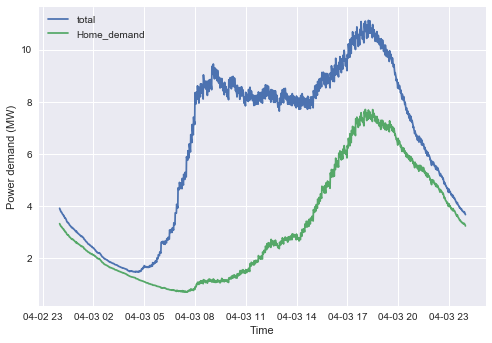

In [14]:
plt.figure()
plt.plot(total_power_demand['total'] / (1000 * 1000))
plt.plot(total_power_demand['Home_demand'] / (1000 * 1000))
plt.ylabel('Power demand (MW)')
plt.xlabel('Time')
plt.legend()
plt.show()

In [16]:
DemandTotal=pd.merge(demandCA18,EVByHour,how='left',on='time')
DemandTotal = DemandTotal.rename(columns={'Cleaned Demand (MW)': 'demand','total':'EVdemand'})
DemandTotal['demandW/OEV']=DemandTotal['demand']-DemandTotal['EVdemand']*5.5
DemandTotal['demandZEV']=DemandTotal['demandW/OEV']+DemandTotal['EVdemand']*84
DemandTotal['demand1/2ZEV']=DemandTotal['demandW/OEV']+DemandTotal['EVdemand']*42
DemandTotal['demand3/4ZEV']=DemandTotal['demandW/OEV']+DemandTotal['EVdemand']*63

DemandTotal.head()
DemandTotal.to_csv("DemandTotal.csv")